# Neural Networks for MNIST dataset

In [2]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.utils.data import Dataset
import numpy as np
import pandas as pd

In [3]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## Loading MNIST
Here we load the dataset and create data loaders.

In [4]:
train_ds = datasets.MNIST('../data', train=True, download=True, 
                       transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
test_ds = datasets.MNIST('../data', train=False, download=True, 
                       transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

In [5]:
batch_size = 64
#batch_size = 5 # for testing
kwargs = {'num_workers': 1, 'pin_memory': True} 

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=False, **kwargs)

## Looking at Examples

In [6]:
train_dl = iter(train_loader)
x, y = next(train_dl)

Process Process-1:
  File "/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 36, in _worker_loop
    r = index_queue.get()
  File "/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/multiprocessing/connection.py", li

In [7]:
print(x.shape, y.shape)

torch.Size([64, 1, 28, 28]) torch.Size([64])


Helper method (from fast.ai)

In [8]:
def show(img, title=None):
    plt.imshow(img, interpolation='none', cmap="gray")
    if title is not None: plt.title(title)

In [9]:
# first from torch to numpy
X = x.numpy(); Y = y.numpy()
X.shape

(64, 1, 28, 28)

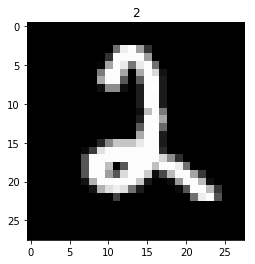

In [10]:
show(X[0][0], Y[0])

In [11]:
print(X[0][0][:4][:4])

[[-0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296]
 [-0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296]
 [-0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421

## Feed Forward Neural Network

In [12]:
# for the number of neurons in the hidden unit
def get_model(M = 300):
    net = nn.Sequential(nn.Linear(28*28, M),
                        nn.ReLU(),
                        nn.Linear(M, 10))
    return net.cuda()

In [19]:
def train_model(train_loader, test_loader, num_epochs, model, optimizer):
    model.train()
    sum_loss = 0.0
    total = 0
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):  
            batch = images.shape[0] # size of the batch
            # Convert torch tensor to Variable, change shape of the input
            images = Variable(images.view(-1, 28*28)).cuda()
            labels = Variable(labels).cuda()
        
            # Forward + Backward + Optimize
            optimizer.zero_grad()  # zero the gradient buffer
            outputs = model(images)
            loss = F.cross_entropy(outputs, labels)
            loss.backward()
            optimizer.step()
        
            total += batch
            sum_loss += batch * loss.data[0]

                
        train_loss = sum_loss/total
        val_acc, val_loss = model_accuracy_loss(model, test_loader)
    return val_acc, val_loss, train_loss

In [14]:
def model_accuracy_loss(model, test_loader):
    model.eval()
    correct = 0
    sum_loss = 0.0
    total = 0
    for images, labels in test_loader:
        images = Variable(images.view(-1, 28*28)).cuda()
        labels = Variable(labels).cuda()
        outputs = model(images)
        _, pred = torch.max(outputs.data, 1)
        loss = F.cross_entropy(outputs, labels)
        sum_loss += labels.size(0)*loss.data[0]
        total += labels.size(0)
        correct += pred.eq(labels.data).cpu().sum()
    return 100 * correct / total, sum_loss/ total

In [15]:
net = get_model()
learning_rate = 0.01
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
model_accuracy_loss(net, test_loader)

(5.75, 2.340800587081909)

In [16]:
train_model(train_loader, test_loader, num_epochs=2, model=net, optimizer=optimizer)

Epoch [1/2], Valid Accuracy: 94.1800, Valid Loss: 0.2170
Epoch [2/2], Valid Accuracy: 95.7100, Valid Loss: 0.1757


(95.71, 0.1756688919067383, 0.2437614460835854)

### 1. Tuning the learning rate

In [20]:
val_acc = []
val_loss = []
train_loss = []
lr_list =  [1, 0.1, 0.01, 0.001, 0.0001, 0.00001]
for i in range(len(lr_list)):
    print(i)
    net = get_model()
    optimizer = optim.Adam(net.parameters(), lr=lr_list[i])
    a,b,c = train_model(train_loader, test_loader, num_epochs=10, model=net, optimizer=optimizer)
    val_acc.append(a)
    val_loss.append(b)
    train_loss.append(c)

0
1
2
3
4
5


In [27]:
def print_table(param, val_acc, val_loss, train_loss):
    '''
    Print the table containing the list of parameters and corresponding accuracy and losses
    '''
    M_tuning = pd.concat([pd.Series(param), pd.Series(val_acc), pd.Series(val_loss), pd.Series(train_loss)], axis = 1)
    M_tuning.columns = ['value', 'val_acc', 'val_loss', 'train_loss']
    print(M_tuning.sort_values(by=['val_acc'], ascending = False))

In [28]:
print_table(lr_list, val_acc, val_loss, train_loss)

     value  val_acc  val_loss  train_loss
3  0.00100    98.00  0.090457    0.055628
4  0.00010    97.73  0.079588    0.159621
2  0.01000    94.57  0.263072    0.184763
5  0.00001    92.69  0.259403    0.470338
0  1.00000    11.40  2.685377   11.867146
1  0.10000    11.13  2.284327    2.184936


Thus, we see that we get the best validation accuracy when `learning rate = 0.001` and the second best when `learning rate = 0.0001`. For interpolating between the 2 we choose from 0.0001, 0.0003, 0.0005, 0.0007, 0.0009, 0.001.

In [29]:
val_acc = []
val_loss = []
train_loss = []
lr_list =  [0.0001, 0.0003, 0.0005, 0.0007, 0.0009, 0.001]
for i in range(len(lr_list)):
    print(i)
    net = get_model()
    optimizer = optim.Adam(net.parameters(), lr=lr_list[i])
    a,b,c = train_model(train_loader, test_loader, num_epochs=10, model=net, optimizer=optimizer)
    val_acc.append(a)
    val_loss.append(b)
    train_loss.append(c)

0
1
2
3
4
5


In [30]:
print_table(lr_list, val_acc, val_loss, train_loss)

    value  val_acc  val_loss  train_loss
1  0.0003    98.08  0.064883    0.083020
3  0.0007    98.01  0.080329    0.059207
2  0.0005    97.97  0.072722    0.064881
5  0.0010    97.79  0.100466    0.056164
4  0.0009    97.73  0.086016    0.057586
0  0.0001    97.67  0.078883    0.159271


Thus we see that the best validation accuracy we get is when learning rate is 0.0003

### 2. Tuning for size of the hidden layer

In [43]:
val_acc = []
val_loss = []
train_loss = []
M = [10, 50, 100, 300, 1000, 2000]
for i in range(len(M)):
    net = get_model(M = M[i])
    optimizer = optim.Adam(net.parameters(), lr=0.01)
    a,b,c = train_model(train_loader, test_loader, num_epochs=10, model=net, optimizer=optimizer)
    val_acc.append(a)
    val_loss.append(b)
    train_loss.append(c)

In [44]:
print_table(M, val_acc, val_loss, train_loss)

   value  val_acc  val_loss  train_loss
4   1000    95.33  0.245196    0.189891
3    300    95.24  0.261072    0.181233
2    100    95.21  0.257378    0.183786
5   2000    95.13  0.279195    0.197609
1     50    94.48  0.284732    0.188099
0     10    90.89  0.330724    0.353767


Here `M = 1000` gives the best validation accuracy. But if we look at the train loss and validation loss, we can see some extent of overfitting. This is particularly true for M = 100 and 300 where there is a difference of ~0.07 between train and validation loss. In these cases while the train loss is reducing a little, validation loss is increasing.

### 3. Adding weight decay for regularisation
To add L2 regularization use the `weight_decay` argument on the optimizer

In [45]:
val_acc = []
val_loss = []
train_loss = []
wd = [0, 0.0001, 0.001, 0.01, 0.1, 0.3]
for i in range(len(wd)):
    net = get_model(M=300)
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=wd[i])
    a,b,c = train_model(train_loader, test_loader, num_epochs=20, model=net, optimizer=optimizer)
    val_acc.append(a)
    val_loss.append(b)
    train_loss.append(c)

In [46]:
print_table(wd, val_acc, val_loss, train_loss)

    value  val_acc  val_loss  train_loss
0  0.0000    98.02  0.122390    0.033368
2  0.0010    97.80  0.068106    0.071450
1  0.0001    97.74  0.090584    0.040079
3  0.0100    96.25  0.142067    0.168552
4  0.1000    90.08  0.437822    0.471097
5  0.3000    84.72  0.796953    0.817350


Thus, we see that weight decay of 0 is giving the best accuracy, but looking at the train and validation loss, I feel that 0.001 may also be a good value for weight decay.

### 4. Adding dropout 

In [84]:
def get_model_v2(M = 300, p=0):
    modules = []
    modules.append(nn.Linear(28*28, M))
    modules.append(nn.ReLU())
    if p > 0:
        modules.append(nn.Dropout(p))
    modules.append(nn.Linear(M, 10))
    return nn.Sequential(*modules).cuda()

In [85]:
val_acc = []
val_loss = []
train_loss = []
dropout = [0.0, 0.2, 0.4, 0.6, 0.8]
for i in range(len(dropout)):
    print(i)
    net2 = get_model_v2(M = 300, p=dropout[i])
    optimizer = optim.Adam(net2.parameters(), lr=0.001)
    a,b,c = train_model(train_loader, test_loader, num_epochs=20, model=net2, optimizer=optimizer)
    val_acc.append(a)
    val_loss.append(b)
    train_loss.append(c)

0
1
2
3
4


In [86]:
print_table(dropout, val_acc, val_loss, train_loss)

   value  val_acc  val_loss  train_loss
2    0.4    98.10  0.107880    0.037922
4    0.8    97.99  0.118072    0.054477
1    0.2    97.94  0.116377    0.035251
3    0.6    97.83  0.130952    0.042333
0    0.0    97.81  0.121619    0.033832


When we add an optimum dropout rate of 0.4, we get the best accuracy of 98.10%. This implies that in the hidden layer, we drop 40% of the neurons, which gives us this validation accuracy. This seems to be an improvement over the model without any dropout.

As compared to the regularised model, dropout has a greater effect on validation accuracy than adding weight decay.

Let's see how the model performs when we reduce the learning rate after 10 epochs. For this we make the new learning rate 0.1 * the old learning rate.

In [87]:
def train_model1(train_loader, test_loader, num_epochs, model, optimizer):
    model.train()
    sum_loss = 0.0
    total = 0
    for epoch in range(num_epochs):
        if epoch == 10:
            optimizer.param_groups[0]['lr'] = optimizer.param_groups[0]['lr']/10
        for i, (images, labels) in enumerate(train_loader):  
            batch = images.shape[0] # size of the batch
            # Convert torch tensor to Variable, change shape of the input
            images = Variable(images.view(-1, 28*28)).cuda()
            labels = Variable(labels).cuda()
        
            # Forward + Backward + Optimize
            optimizer.zero_grad()  # zero the gradient buffer
            outputs = model(images)
            loss = F.cross_entropy(outputs, labels)
            loss.backward()
            optimizer.step()
        
            total += batch
            sum_loss += batch * loss.data[0]
               
        train_loss = sum_loss/total
        val_acc, val_loss = model_accuracy_loss(model, test_loader)
    return val_acc, val_loss, train_loss

In [88]:
val_acc = []
val_loss = []
train_loss = []
dropout = [0.0, 0.2, 0.4, 0.6, 0.8]
for i in range(len(dropout)):
    print(i)
    net2 = get_model_v2(M = 300, p=dropout[i])
    optimizer = optim.Adam(net2.parameters(), lr=0.001)
    a,b,c = train_model1(train_loader, test_loader, num_epochs=20, model=net2, optimizer=optimizer)
    val_acc.append(a)
    val_loss.append(b)
    train_loss.append(c)

0
1
2
3
4


In [89]:
print_table(dropout, val_acc, val_loss, train_loss)

   value  val_acc  val_loss  train_loss
4    0.8    98.53  0.067169    0.049024
0    0.0    98.51  0.074585    0.029049
3    0.6    98.46  0.068792    0.036483
1    0.2    98.44  0.078536    0.029695
2    0.4    98.34  0.078277    0.032416


Here, we see a significant increase in the validation accuracy when we change the learning rate by a tenth after 10 epochs. In this case, dropout = 0.8 gave the highest validation accuracy of 98.53%.

## Q3. 3-layer network

Here, I am defining a neural net that by default has a layer size of 300 and then 150 and initial p = 0, i.e. no dropouts.

In [65]:
def get_model_v3(M = 300, p=0):
    modules = []
    modules.append(nn.Linear(28*28, M))
    modules.append(nn.ReLU())
    if p > 0:
        modules.append(nn.Dropout(p))
    modules.append(nn.Linear(M, 150))
    modules.append(nn.ReLU())
    if p > 0:
        modules.append(nn.Dropout(p))    
    modules.append(nn.Linear(150, 10))
    return nn.Sequential(*modules).cuda()

Let us first tune the learning rate for values in 1, 0.1, 0.01, 0.001, 0.0001, 0.00001.

In [68]:
val_acc = []
val_loss = []
train_loss = []
lr_list =  [1, 0.1, 0.01, 0.001, 0.0001, 0.00001]
for i in range(len(lr_list)):
    print(i)
    net = get_model_v3()
    optimizer = optim.Adam(net.parameters(), lr=lr_list[i])
    a,b,c = train_model(train_loader, test_loader, num_epochs=10, model=net, optimizer=optimizer)
    val_acc.append(a)
    val_loss.append(b)
    train_loss.append(c)

0
1
2
3
4
5


In [69]:
print_table(lr_list, val_acc, val_loss, train_loss)

     value  val_acc   val_loss  train_loss
3  0.00100    98.17   0.078053    0.059021
4  0.00010    97.86   0.069875    0.140632
2  0.01000    96.43   0.181646    0.158323
5  0.00001    93.10   0.235993    0.457318
1  0.10000    11.35   2.307264    2.433067
0  1.00000    10.09  29.622449  151.479984


So we see that the best most optimal learning rate is 0.001. Going ahead, we will keep this learning rate fixed.
### Tuning the size of the hidden layer
Now that we have found the best learning rate, let us fix the number of neurons in the first hidden layer. The size of the second is kept fixed at 150 neurons.

In [78]:
val_acc = []
val_loss = []
train_loss = []
M = [10, 50, 100, 300, 1000, 2000]
for i in range(len(M)):
    print(i)
    net = get_model_v3(M = M[i])
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    a,b,c = train_model(train_loader, test_loader, num_epochs=10, model=net, optimizer=optimizer)
    val_acc.append(a)
    val_loss.append(b)
    train_loss.append(c)

0
1
2
3
4
5


In [79]:
print_table(M, val_acc, val_loss, train_loss)

   value  val_acc  val_loss  train_loss
4   1000    98.41  0.072650    0.053336
3    300    98.03  0.086128    0.058674
2    100    97.60  0.096461    0.072188
1     50    97.50  0.091975    0.088726
5   2000    97.20  0.156515    0.053430
0     10    94.20  0.188927    0.212718


Here M = 1000 seems to give the best validation accuracy. Going forward, we will use this as the number of neurons in the first hidden layer.

### Adding L2 regularisation 
After fixing the size of the hidden layer, we try to add regularisation

In [95]:
val_acc = []
val_loss = []
train_loss = []
wd = [0, 0.0001, 0.001, 0.01, 0.1, 0.3]
for i in range(len(wd)):
    print(i)
    net = get_model_v3(M=1000)
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=wd[i])
    a,b,c = train_model(train_loader, test_loader, num_epochs=10, model=net, optimizer=optimizer)
    val_acc.append(a)
    val_loss.append(b)
    train_loss.append(c)

0
1
2
3
4
5


In [96]:
print_table(wd, val_acc, val_loss, train_loss)

    value  val_acc  val_loss  train_loss
0  0.0000    97.94  0.094614    0.053649
1  0.0001    97.93  0.071775    0.060677
2  0.0010    97.12  0.089322    0.087501
3  0.0100    96.14  0.146321    0.175382
4  0.1000    87.92  0.521089    0.564228
5  0.3000    65.77  1.223724    1.246326


Here we see that without weight decay, we get the best validation accuracy. But I feel that the validation loss being much lower at weight decay = 0.0001 also implies that this could be the optimal value.

### Adding dropout without regularisation

In [97]:
val_acc = []
val_loss = []
train_loss = []
dropout = [0.0, 0.2, 0.4, 0.6, 0.8]
for i in range(len(dropout)):
    print(i)
    net = get_model_v3(M = 1000, p=dropout[i])
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    a,b,c = train_model(train_loader, test_loader, num_epochs=10, model=net, optimizer=optimizer)
    val_acc.append(a)
    val_loss.append(b)
    train_loss.append(c)

0
1
2
3
4


In [98]:
print_table(dropout, val_acc, val_loss, train_loss)

   value  val_acc  val_loss  train_loss
2    0.4    97.97  0.093606    0.066110
3    0.6    97.93  0.085355    0.080290
0    0.0    97.81  0.100169    0.054286
4    0.8    97.80  0.091906    0.121479
1    0.2    97.62  0.128524    0.058547


Here the highest validation accuracy is when dropout rate = 0.4. 
Let's now combine dropout = 0.4 and weight decay = 0.0001 and see what we get.

## Final model

In [101]:
net = get_model_v3(M = 1000, p=0.4)
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.0001)
val_acc,val_loss,train_loss = train_model(train_loader, test_loader, num_epochs=10, model=net, optimizer=optimizer)

In [103]:
print('Validation accuracy = ' + str(val_acc) + ', validation loss = ' + str(val_loss) + ', train loss = ' + str(train_loss))

Validation accuracy = 98.03, validation loss = 0.06831177916526794, train loss = 0.07197758896847566
